<a href="https://colab.research.google.com/github/cmannnn/predict_future_sales/blob/barebone_xgboost/predict_future_sales_barebone_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Sales

# Imports and uploads

In [ ]:
# imports
import os

import gc

import time

import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import tensorflow as tf


#import specific sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

#encoders, tested several of them
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import make_pipeline

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from xgboost import plot_importance


# root path for running on Google Colab
root_path = 'drive/MyDrive/Camp Jupyter/predict_future_sales_data/kaggle_data/'

In [ ]:
# Google Colab mount - don't run this when running locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing All Predict Sales Data

In [ ]:
#importing all the data frames



# root path for running locally
# sumeet root_path
#root_path='./'
# chris root_path
#root_path = '/Users/cman/Desktop/商务/datasets/predict_future_sales/'

itemcats_df = pd.read_csv(root_path+"item_categories.csv", encoding= 'unicode_escape') #Item Categories
items_df = pd.read_csv(root_path+"items.csv", encoding= 'unicode_escape') # Items
salestrain_df = pd.read_csv(root_path+"sales_train.csv", encoding= 'unicode_escape') #Sales Data - Training
salestrain_df.date = pd.to_datetime(salestrain_df.date)
shops_df = pd.read_csv(root_path+"shops.csv", encoding= 'unicode_escape') # Shops
usd_rus_df = pd.read_csv(root_path+'USD-RUS.csv')
usd_rus_df.Date = pd.to_datetime(usd_rus_df.Date)

# sample submission dataframe
sample_df = pd.read_csv(root_path+'sample_submission.csv')

# test data frame
test_df = pd.read_csv(root_path+'test.csv')

In [ ]:
# combining training dataframes into master training set
salestrain_df_combined = salestrain_df.merge(items_df, on = 'item_id')
salestrain_df_combined = salestrain_df_combined.merge(itemcats_df, on = 'item_category_id')
salestrain_df_combined = salestrain_df_combined.merge(shops_df, on = 'shop_id')

# adding features for separating date
salestrain_df_combined['year'] = salestrain_df_combined.date.dt.year
salestrain_df_combined['month'] = salestrain_df_combined.date.dt.month
salestrain_df_combined['day'] = salestrain_df_combined.date.dt.day

# adding revenue column
salestrain_df_combined['revenue'] = salestrain_df_combined.item_price * salestrain_df_combined.item_cnt_day

# adding a random feature
salestrain_df_combined['Random'] = salestrain_df_combined.apply(lambda x: np.random.randint(100),axis = 'columns')

# creating a new feature: 'month-year'
salestrain_df_combined['month-year'] = salestrain_df_combined['date'].apply(lambda x: str(x.month) + '-' + str(x.year) if x.month >= 10 else '0' + str(x.month) + '-' + str(x.year)) 

##Merging USD - RUS currency conversion to salestrain_df_combined

In [ ]:
# merging exchange rate data to master dataframe
salestrain_df_combined = salestrain_df_combined.merge(usd_rus_df[['Date','Open']], left_on = 'date', right_on = 'Date')

In [ ]:
# dropping the duplicated date col from 
salestrain_df_combined.drop(['Date'], axis = 'columns', inplace = True)

In [ ]:
# renaming the 'Open' col to 'USD_RUS' from the USD RUS conversion dataframe
salestrain_df_combined.rename({'Open':'USD_RUS'}, axis = 'columns', inplace = True)

In [ ]:
# caltulating the price based on the conversion rate
salestrain_df_combined['USD_Price'] = salestrain_df_combined['item_price'] / salestrain_df_combined['USD_RUS']

In [ ]:
# checking the df head
salestrain_df_combined.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue,Random,month-year,USD_RUS,USD_Price
0,2013-02-01,0,59,22154,999.00,1.0,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.00,87,02-2013,29.9816,33.320437
1,2013-02-01,0,59,17482,599.38,1.0,PROMETEY (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,599.38,63,02-2013,29.9816,19.991595
2,2013-02-01,0,59,16626,312.03,1.0,OPINION (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,312.03,87,02-2013,29.9816,10.407383


## Remove Outliers above 600 sales per day

In [ ]:
for i in range(0,22):
    print(i,len(salestrain_df_combined[salestrain_df_combined['item_cnt_day']> i * 100]))

0 1921686
1 130
2 34
3 21
4 17
5 11
6 5
7 2
8 2
9 2
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1


In [ ]:
#salestrain_df_combined = salestrain_df_combined[salestrain_df_combined['item_cnt_day'] <= 600]

In [ ]:
# creating 'month_id' col to enumerate month col
salestrain_df_combined['month_id'] = (salestrain_df_combined['year'] - 2014) * 12 + salestrain_df_combined['month']

# Lagging Features

*   Item Sales Lag (1, 2, 3, 6 , 12 months)
*   Combination of Items and Shops
*   Shop Sales Lag
*   Shop-Category Lag

## creating store_id + item_id based lag features

In [ ]:
# checking col data types
salestrain_df_combined.dtypes

date                  datetime64[ns]
date_block_num                 int64
shop_id                        int64
item_id                        int64
item_price                   float64
item_cnt_day                 float64
item_name                     object
item_category_id               int64
item_category_name            object
shop_name                     object
year                           int64
month                          int64
day                            int64
revenue                      float64
Random                         int64
month-year                    object
USD_RUS                      float64
USD_Price                    float64
month_id                       int64
dtype: object

In [ ]:
# changing data types to save space
salestrain_df_combined.astype({'date_block_num': 'int16', 'shop_id':'int16', 'item_id':'int16', 'item_price':'float16', 'item_cnt_day':'float16', 
                              'item_category_id':'int16', 'year':'int16', 'month':'int16', 'day':'int16', 'revenue':'float16', 'Random':'int16', 
                              'USD_RUS':'float16', 'USD_Price':'float16', 'month_id':'int16'})

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue,Random,month-year,USD_RUS,USD_Price,month_id
0,2013-02-01,0,59,22154,999.0,1.0,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.0,87,02-2013,29.984375,33.312500,-10
1,2013-02-01,0,59,17482,599.5,1.0,PROMETEY (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,599.5,63,02-2013,29.984375,19.984375,-10
2,2013-02-01,0,59,16626,312.0,1.0,OPINION (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,312.0,87,02-2013,29.984375,10.406250,-10
3,2013-02-01,0,59,17491,199.0,1.0,PROFESSIONAL (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,199.0,15,02-2013,29.984375,6.636719,-10
4,2013-02-01,0,59,8714,199.0,1.0,NO COMPROMISES (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,199.0,88,02-2013,29.984375,6.636719,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927068,2013-01-01,0,14,16203,599.0,1.0,"Board game Russkiy Preferans, art. 1969",64,Gifts - Board Games,"Kazan shopping mall of ""Parkhouse"" II of",2013,1,1,599.0,90,01-2013,30.500000,19.640625,-11
1927069,2013-01-01,0,14,15438,599.0,1.0,Toy Sojuzmultfilm Pooh music,63,Gifts - Soft Toys,"Kazan shopping mall of ""Parkhouse"" II of",2013,1,1,599.0,78,01-2013,30.500000,19.640625,-11
1927070,2013-01-01,0,14,9362,299.0,1.0,Keychain Sochi 2014 White bear with scarf 12cm,70,Gifts - Souvenirs (weighed in),"Kazan shopping mall of ""Parkhouse"" II of",2013,1,1,299.0,93,01-2013,30.500000,9.804688,-11
1927071,2013-01-01,0,14,22088,79.0,2.0,Battery DURACELL LR06-BC2,83,batteries,"Kazan shopping mall of ""Parkhouse"" II of",2013,1,1,158.0,92,01-2013,30.500000,2.589844,-11


In [ ]:
#group_bys = ['item_id', 'shop_id']
#target_column='item_cnt_day'

#Make a list of columns we want to keep from the df
#group_by_cols = group_bys.copy()
#group_by_cols.append('year')
#group_by_cols.append('month')
#group_by_cols.append('month_id')
#group_by_cols.append(target_column)

#Make a dataframe with just the columns we need
#tmp_df=salestrain_df_combined[group_by_cols]

#Sort by group_by_vars, then month and year
#tmp_df.sort_values(by = group_by_cols, inplace = True)

#shop_id = 1
#print(shop_id)

#ssid
#ssid = tmp_df[tmp_df['shop_id'] == shop_id]

# pivot individual ssid
#ssid = ssid.pivot_table(index = group_bys, columns = 'month_id', values = target_column, aggfunc = np.sum)

#ssid.head()

In [ ]:
# function that takes group_by defined cols to pivot by month (1-12) 
def make_lag_features(df = salestrain_df_combined, target_column = 'item_cnt_day', group_bys = ['item_id', 'shop_id']):
  master_df = pd.DataFrame()

  #Make a list of columns we want to keep from the df
  group_by_cols = group_bys.copy()
  group_by_cols.append('year')
  group_by_cols.append('month')
  group_by_cols.append('month_id')
  group_by_cols.append(target_column)

  #Make a dataframe with just the columns we need
  tmp_df = df[group_by_cols]

  #Sort by group_by_vars, then month and year
  tmp_df.sort_values(by = group_by_cols, inplace = True)

  # main shop_id pivot loop 
  for shop_id in tmp_df.shop_id.unique():

    # printing shop_ids that are getting split
    print(f'SHOP IDS: {shop_id}')

    # creating ssid
    ssid = tmp_df[tmp_df['shop_id'] == shop_id]

    # pivot tabling 
    ssid = ssid.pivot_table(index = group_bys, columns = 'month_id', values = target_column, aggfunc = np.sum)
    ssid = ssid.reindex(pd.MultiIndex.from_product(ssid.index.levels, names = ssid.index.names))

    # Fill NAs with zeros
    ssid.fillna(0, inplace = True)

    # stacking the multilevel's x2 and resetting the index
    ssid = ssid.stack().reset_index()

    # renaming the calculated column to 'item_cnt_month_shop_id'
    lag_feature_name = 'By_'

    # Build the target column name
    for item in group_bys:
      lag_feature_name = lag_feature_name + item + '-'

    lag_feature_name = lag_feature_name[:-1]

    # Rename the '0' column with the name of the group_bys
    ssid.rename({0:lag_feature_name}, inplace = True, axis = 1)

    # looping through number dictionary to add 1-12 month lags to columns
    for i in np.arange(1,12+1):
      ssid[lag_feature_name + '_' + str(i) + '_month_ago'] = ssid[lag_feature_name].shift(i)

    # removing year 2013 because there are NaN values in lagged columns 
    ssid = ssid.loc[tmp_df['month_id'] > 0]

    # concating the individual ssid's into new DataFrame
    master_df = pd.concat([master_df,ssid])

  return master_df

In [ ]:
#plt.figure(figsize = (20, 10))

#sns.boxplot(x = make_lag_features()['By_item_id-shop_id'])

#sns.boxplot(x = shop_id_month_stack['item_price'], ax = ax2)

#sns.boxplot(x = shop_id_month_stack['USD_Price'], ax = ax3)

#sns.boxplot(x = shop_id_month_stack['revenue'], ax = ax4)

#plt.tight_layout()

# quick XGBoost

In [ ]:
# removing 'year' and 'month' unecessary columns and assigning function to shop_id_month_stack
shop_id_month_stack = make_lag_features()[['item_id', 'shop_id', 'month_id', 'By_item_id-shop_id',
       'By_item_id-shop_id_1_month_ago', 'By_item_id-shop_id_2_month_ago',
       'By_item_id-shop_id_3_month_ago', 'By_item_id-shop_id_4_month_ago',
       'By_item_id-shop_id_5_month_ago', 'By_item_id-shop_id_6_month_ago',
       'By_item_id-shop_id_7_month_ago', 'By_item_id-shop_id_8_month_ago',
       'By_item_id-shop_id_9_month_ago', 'By_item_id-shop_id_10_month_ago',
       'By_item_id-shop_id_11_month_ago', 'By_item_id-shop_id_12_month_ago']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


SHOP IDS: 54
SHOP IDS: 55
SHOP IDS: 44
SHOP IDS: 25
SHOP IDS: 31
SHOP IDS: 2
SHOP IDS: 3
SHOP IDS: 4
SHOP IDS: 5
SHOP IDS: 7
SHOP IDS: 12
SHOP IDS: 14
SHOP IDS: 15
SHOP IDS: 16
SHOP IDS: 18
SHOP IDS: 19
SHOP IDS: 21
SHOP IDS: 24
SHOP IDS: 26
SHOP IDS: 27
SHOP IDS: 28
SHOP IDS: 29
SHOP IDS: 32
SHOP IDS: 45
SHOP IDS: 6
SHOP IDS: 22
SHOP IDS: 30
SHOP IDS: 35
SHOP IDS: 37
SHOP IDS: 38
SHOP IDS: 42
SHOP IDS: 43
SHOP IDS: 46
SHOP IDS: 47
SHOP IDS: 50
SHOP IDS: 51
SHOP IDS: 53
SHOP IDS: 56
SHOP IDS: 59
SHOP IDS: 0
SHOP IDS: 1
SHOP IDS: 8
SHOP IDS: 10
SHOP IDS: 13
SHOP IDS: 23
SHOP IDS: 41
SHOP IDS: 48
SHOP IDS: 52
SHOP IDS: 57
SHOP IDS: 58
SHOP IDS: 17
SHOP IDS: 34
SHOP IDS: 39
SHOP IDS: 49
SHOP IDS: 33
SHOP IDS: 36
SHOP IDS: 11
SHOP IDS: 40
SHOP IDS: 9
SHOP IDS: 20


In [ ]:
# checking the df head
shop_id_month_stack.head()

,item_id,shop_id,month_id,By_item_id-shop_id,By_item_id-shop_id_1_month_ago,By_item_id-shop_id_2_month_ago,By_item_id-shop_id_3_month_ago,By_item_id-shop_id_4_month_ago,By_item_id-shop_id_5_month_ago,By_item_id-shop_id_6_month_ago,By_item_id-shop_id_7_month_ago,By_item_id-shop_id_8_month_ago,By_item_id-shop_id_9_month_ago,By_item_id-shop_id_10_month_ago,By_item_id-shop_id_11_month_ago,By_item_id-shop_id_12_month_ago
19418,1525,54,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19419,1525,54,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19420,1525,54,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19421,1525,54,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19422,1525,54,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## You can use this cell to reload the entire training dataset instead of running the notebook above

In [ ]:
# saving dataframe in case runtime error causes problems
# shop_id_month_stack.to_csv(root_path+'full_dataframe.csv')

In [ ]:
#shop_id_month_stack = pd.read_csv(root_path+'full_dataframe.csv')

In [ ]:
# setting training set
X_train = shop_id_month_stack.loc[shop_id_month_stack['month_id'] < 24]
X_train = X_train.drop(['By_item_id-shop_id'], axis = 1)
y_train = shop_id_month_stack.loc[shop_id_month_stack['month_id'] < 24]['By_item_id-shop_id']

# setting testing set
X_val = shop_id_month_stack.loc[shop_id_month_stack['month_id'] == 24]
X_val = X_val.drop(['By_item_id-shop_id'], axis = 1)
y_val = shop_id_month_stack.loc[shop_id_month_stack['month_id'] == 24]['By_item_id-shop_id']

In [ ]:
# checking X_train head
X_train.head()

,item_id,shop_id,month_id,By_item_id-shop_id_1_month_ago,By_item_id-shop_id_2_month_ago,By_item_id-shop_id_3_month_ago,By_item_id-shop_id_4_month_ago,By_item_id-shop_id_5_month_ago,By_item_id-shop_id_6_month_ago,By_item_id-shop_id_7_month_ago,By_item_id-shop_id_8_month_ago,By_item_id-shop_id_9_month_ago,By_item_id-shop_id_10_month_ago,By_item_id-shop_id_11_month_ago,By_item_id-shop_id_12_month_ago
19418,1525,54,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19419,1525,54,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19420,1525,54,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19421,1525,54,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19422,1525,54,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# getting order of X_train cols for XGBoost
train_col_order = X_train.columns

In [ ]:
# checking X_val head
X_val.head()

,item_id,shop_id,month_id,By_item_id-shop_id_1_month_ago,By_item_id-shop_id_2_month_ago,By_item_id-shop_id_3_month_ago,By_item_id-shop_id_4_month_ago,By_item_id-shop_id_5_month_ago,By_item_id-shop_id_6_month_ago,By_item_id-shop_id_7_month_ago,By_item_id-shop_id_8_month_ago,By_item_id-shop_id_9_month_ago,By_item_id-shop_id_10_month_ago,By_item_id-shop_id_11_month_ago,By_item_id-shop_id_12_month_ago
19439,1525,54,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19475,1527,54,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19511,1528,54,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19547,1530,54,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19583,1531,54,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# setting timer
ts = time.time()

# XGBoost model
model = XGBRegressor(
    max_depth = 10,
    n_estimators = 2000,
    min_child_weight = 300, 
    colsample_bytree = 0.8, 
    subsample = 0.8, 
    eta = 0.5,    
    seed = 42)

# fitting the model to data
model.fit(
    X_train, 
    y_train, 
    eval_metric = "rmse", 
    eval_set = [(X_train, y_train), (X_val, y_val)], 
    verbose = True, 
    early_stopping_rounds = 10)

print(f'The model took: {time.time() - ts} seconds')

[14:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.218	validation_1-rmse:0.755046
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.17489	validation_1-rmse:0.719325
[2]	validation_0-rmse:2.14225	validation_1-rmse:0.678026
[3]	validation_0-rmse:2.10719	validation_1-rmse:0.650127
[4]	validation_0-rmse:2.07896	validation_1-rmse:0.627242
[5]	validation_0-rmse:2.05777	validation_1-rmse:0.612401
[6]	validation_0-rmse:2.04089	validation_1-rmse:0.592088
[7]	validation_0-rmse:2.02291	validation_1-rmse:0.580122
[8]	validation_0-rmse:2.00859	validation_1-rmse:0.57545
[9]	validation_0-rmse:1.99447	validation_1-rmse:0.559455
[10]	validation_0-rmse:1.98222	validation_1-rmse:0.551714
[11]	validation_0-rmse:1.97039	validation_1-rmse:0.545397
[12]	validation_0-rmse:1.95976	

In [ ]:
# saving model as pickle file
#import pickle

#xgboost_pickle = 'xgboost_pickle.pkl'
#with open(xgboost_pickle, 'wb') as file:
#  pickle.dump(model, file)

## Matching output to test_df for submission

In [ ]:
# checking length of test_df
print(f'Submission must contain {len(test_df)} rows')

Submission must contain 214200 rows


In [ ]:
# grabbing only the 24th month data from pivoted train data
shop_id_month_stack_last_month = shop_id_month_stack[shop_id_month_stack['month_id'] == 24]

# merging the test_df with the 24th month pivoted train data
test_df_merged = pd.merge(test_df, shop_id_month_stack_last_month, how = 'left', on = ['item_id', 'shop_id'])

# filling all NaN's with 0
test_df_merged.fillna(0, inplace = True)

In [ ]:
# This item is NOT in the train dataframe, but it IS in the test_df, so the result should be an empty DF
shop_id_month_stack_last_month[shop_id_month_stack_last_month['item_id'] == 5320]

,item_id,shop_id,month_id,By_item_id-shop_id,By_item_id-shop_id_1_month_ago,By_item_id-shop_id_2_month_ago,By_item_id-shop_id_3_month_ago,By_item_id-shop_id_4_month_ago,By_item_id-shop_id_5_month_ago,By_item_id-shop_id_6_month_ago,By_item_id-shop_id_7_month_ago,By_item_id-shop_id_8_month_ago,By_item_id-shop_id_9_month_ago,By_item_id-shop_id_10_month_ago,By_item_id-shop_id_11_month_ago,By_item_id-shop_id_12_month_ago


In [ ]:
# creating a copy of the test_df_merged
test_df_clean = test_df_merged.copy()

# for loop to drop un-needed columns for submission
for col_name in ['Unnamed: 0', 'ID', 'item_cnt_month_shop_id', 'By_item_id-shop_id']:
    try:
        test_df_clean = test_df_clean.drop(col_name, axis = 1)
    except:
        pass

# setting the order of the test_df_clean for XGBoost
test_df_clean = test_df_clean[train_col_order]

In [ ]:
#checking test_df_clean head
test_df_clean.head()

,item_id,shop_id,month_id,By_item_id-shop_id_1_month_ago,By_item_id-shop_id_2_month_ago,By_item_id-shop_id_3_month_ago,By_item_id-shop_id_4_month_ago,By_item_id-shop_id_5_month_ago,By_item_id-shop_id_6_month_ago,By_item_id-shop_id_7_month_ago,By_item_id-shop_id_8_month_ago,By_item_id-shop_id_9_month_ago,By_item_id-shop_id_10_month_ago,By_item_id-shop_id_11_month_ago,By_item_id-shop_id_12_month_ago
0,5037,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5320,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5233,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5232,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5268,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# checking to see if length of pivoted dataframe equals length of test_df
if len(test_df_clean) == len(test_df):
  print('length of test and pivoted dataframe match!')
else:
  print('length of test and pivoted dataframe don\'t match')

length of test and pivoted dataframe match!


In [ ]:
# grabbing only 25th month for submission
test_df_clean['month_id'] = 25

In [ ]:
# predicting test_df_clean
y_pred_test = model.predict(test_df_clean)
#.clip(0, 20)

In [ ]:
# creating copy of test_df_clean_for_submission
test_df_clean_for_submission = test_df_clean.copy()

# ordering dataframe by ID col
test_df_clean_for_submission['ID'] = np.arange(0, 214200)

# inserting prediction into the item_cnt_month col
test_df_clean_for_submission['item_cnt_month'] = y_pred_test

# checking test_df_clean_for_submission head
test_df_clean_for_submission.head()

,item_id,shop_id,month_id,By_item_id-shop_id_1_month_ago,By_item_id-shop_id_2_month_ago,By_item_id-shop_id_3_month_ago,By_item_id-shop_id_4_month_ago,By_item_id-shop_id_5_month_ago,By_item_id-shop_id_6_month_ago,By_item_id-shop_id_7_month_ago,By_item_id-shop_id_8_month_ago,By_item_id-shop_id_9_month_ago,By_item_id-shop_id_10_month_ago,By_item_id-shop_id_11_month_ago,By_item_id-shop_id_12_month_ago,ID,item_cnt_month
0,5037,5,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.112635
1,5320,5,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.110691
2,5233,5,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.112635
3,5232,5,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.112635
4,5268,5,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.112635


In [ ]:
# trimming submission dataframe to just 'ID' and 'item_cnt_month' cols 
submission_df = test_df_clean_for_submission[['ID','item_cnt_month']]

In [ ]:
# checking submission_df
submission_df.head()

,ID,item_cnt_month
0,0,0.112635
1,1,0.110691
2,2,0.112635
3,3,0.112635
4,4,0.112635


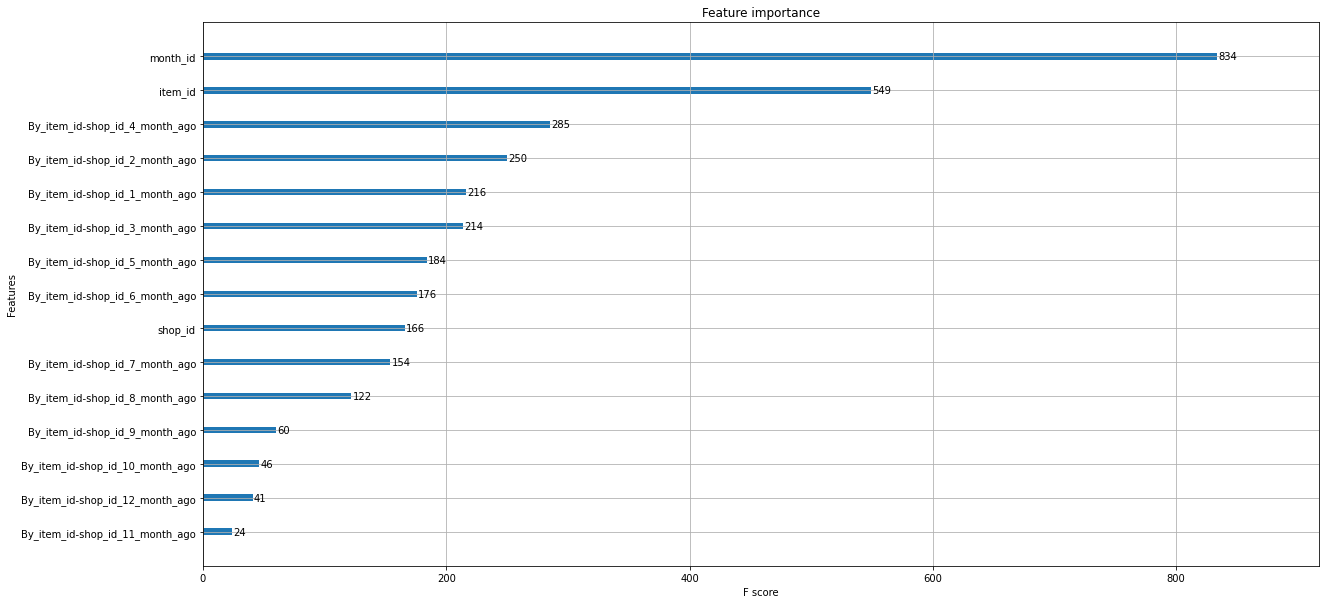

In [ ]:
# creating function to plot features
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    return plot_importance(booster = booster, ax = ax)

plot_features(model, (20,10))

#plt.savefig('drive/MyDrive/Camp Jupyter/predict_future_sales_data/xgboost.png')

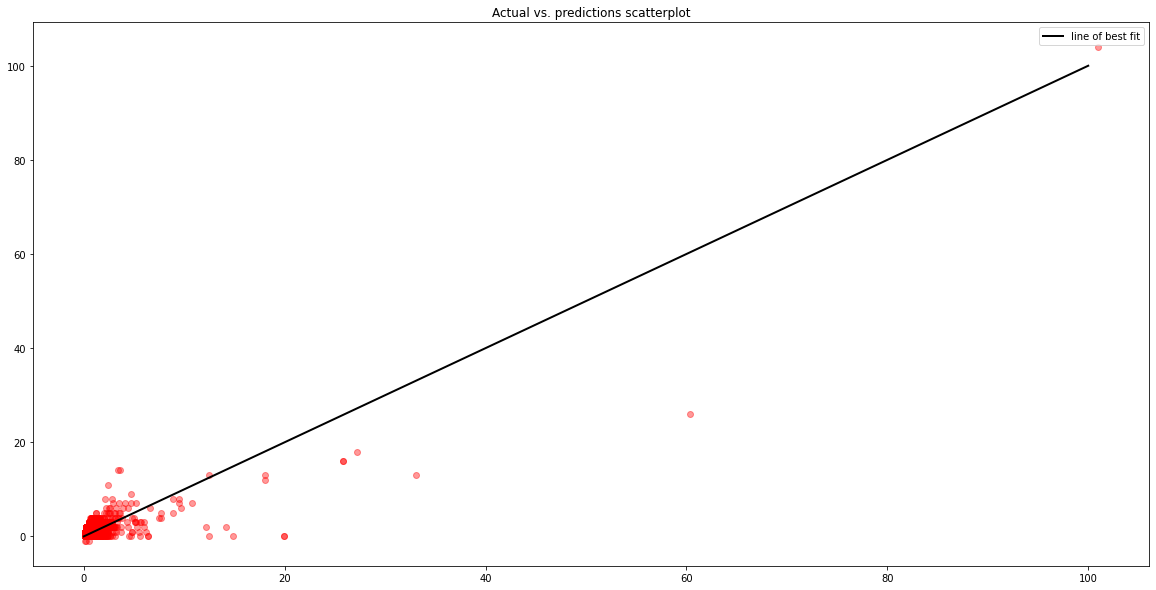

In [ ]:
# scatterplot predictions and actual
fig, ax = plt.subplots(1, figsize = (20, 10))
plt.scatter(x = y_pred_test, y = test_df_clean['By_item_id-shop_id_1_month_ago'], c = 'r', alpha = 0.4)
plt.plot([0, 100], [0, 100], color = 'black', linewidth = 2, label = 'line of best fit')

#plt.xlim(0, 5)
#plt.ylim(-0.5, 20)

plt.title('Actual vs. predictions scatterplot')

#plt.savefig('drive/MyDrive/Camp Jupyter/predict_future_sales_data/xgboost_scatter.png')

In [ ]:
# save submission to upload to Kaggle -- update date in file path!
submission_df.to_csv('sample_2021-0501.csv', index = False)